# **Nelder Mead Implementation**

In [ ]:
! pip install pyDOE #Latin Hypercube Sampling
! pip install plotting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=a4a141ee3abd6a0d7db7e59204f99597ca4e6f42d722f8989fc7ca76dc88775c
  Stored in directory: /root/.cache/pip/wheels/83/ce/8a/87b25c685bfeca1872d13b8dc101e087a9c6e3fb5ebb47022a
Successfully built pyDOE
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import operator
import imageio
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def order(points, function, **kw):
    
    # dictionary for the objective function {point: value}
    obj_func = {}
    # number of oracle calls (initialized)
    oc = 0
    
    # for each point in simplex
    for point in points:
        
        # put point and functiion value in dictionary
        # point in tuple, because arrays and lists are not hashable
        obj_func[tuple(point)] = function(point, **kw)
        # increment of the oracle calls number
        oc += 1
    
    # sort dictionary by value
    obj_func = sorted(obj_func.items(), key=operator.itemgetter(1))
    
    # ordered points of simplex
    ordered_points = np.array([of[0] for of in obj_func])
    # values of the objective function in the ordered points
    ordered_of_values = np.array([of[1] for of in obj_func])
    
    # if any of the values is NaN, raise an exception
    if np.any(np.isnan(ordered_of_values)):
        raise Exception('NaN values in simplex')
    
    return ordered_points, ordered_of_values, oc
    
def centroid(ordered_points):
    
    # n best points in the (n+1)-simplex
    points = ordered_points[:-1]
    
    # x_0 = mean(points)
    center = np.sum(points, axis=0) / points.shape[0]
    
    return center

def reflection(worst_point, center, alpha):

    # if the reflection coefficient is negative, raise an exception (point doesn't overlap over centroid)
    if alpha <= 0.:
        raise Exception('Reflection coefficient is negative: {}'.format(alpha))
    
    # x_reflected = -alpha * x_worst + (1 + alpha) * x_0
    reflected_point = center + alpha * (center - worst_point)
    
    return reflected_point

def expansion(reflected_point, center, gamma):
    
    # if the expansion coefficient is less than 1, raise an exception (contraction of the reflected point towards centroid)
    if gamma <= 1.:
        raise Exception('Expansion coefficient is invalid (gamma > 1.0): {}'.format(gamma))
    
    # x_expanded = gamma * x_reflected + (1 - gamma) * x_0
    expanded_point = center + gamma * (reflected_point - center)
    
    return expanded_point

def contraction(worst_point, center, beta):
    
    # if the contraction coefficient is negative, raise an exception (overlaps over centroid)
    # if the contraction coefficient is greater than 0.5, raise an exception (insufficient contraction)
    if (beta <= 0.) or (beta > 0.5):
        raise Exception('Reflection coefficient is invalid (0.0 < beta <= 0.5): {}'.format(beta))
    
    # x_contracted = beta * x_worst + (1 - beta) * x_0
    contracted_point = center + beta * (worst_point - center)
    
    return contracted_point

def shrinkage(ordered_points, sigma):

    if (sigma <= 0.) or (sigma >= 1.):
        raise Exception('Shrink coefficient is invalid (0.0 < sigma <= 1.0): {}'.format(sigma))
    
    # array for shrinked simplex
    shrinked_points = np.copy(ordered_points)
    
    # for each point in simplex, except for the best one
    for (i, point) in enumerate(ordered_points[1:]):
        
        # x_shrinked = sigma * x + (1 - sigma) * x_best
        shrinked_points[i+1] = ordered_points[0] + sigma * (point - ordered_points[0])
        
    return shrinked_points

def terminate(points, eps_s, eps_a):
    def roll_cut(arr, dims, roll_num):
        # if there are overlays in rolling combinations
        if (dims % 2 == 0):
            # cut the first and last overlayed elements
            new_arr = arr[1:-roll_num]
        # if there are none
        else:
            # cut only first element
            new_arr = arr[1:]
            
        return new_arr
    
    # number of points in simplex
    dims = points.shape[0]
    
    # if there are less than 3 points, the Nelder-Mead algorithm is unfit
    if dims < 3:
        raise Exception('Invalid amount of points in simplex: {}'.format(dims))
    
    # number of rolls, necessary to compute the vectors of simplex sides
    roll_num = dims / 2
    
    # array of simplex sides vectors to be filled
    vecs = np.zeros((1, dims - 1))
    
    # after each roll
    for i in range(roll_num):
        vecs = np.vstack((vecs, points - np.roll(points, i+1, axis=0)))
    
    # in dependency to the number of points (even), cut repeating vectors ({CA} and {DB} in example above)
    vecs = roll_cut(vecs, dims, roll_num)
    
    # sides of the simplex
    norms = np.linalg.norm(vecs, axis=1)
    
    # number of vectors
    vec_dims = vecs.shape[0]
    # number of rolls, necessary to compute the vectors dot products (and areas between them)
    vec_roll_num = vec_dims / 2
    
    # array of areas between each couple of vectors to be filled
    areas = np.zeros((1, ))
    
    # after each vectors' roll (same procedure as for points rolling)
    for i in range(vec_roll_num):
        
        # vectors' roll
        rolled_vecs = np.roll(vecs, i+1, axis=0)
        # dot products of different vectors squared <x,y>^2
        dot_prod_sqr = np.einsum('ij,ij->i', vecs, rolled_vecs)**2
        # norms of x vecor squared |x|^2
        vec_norm_sqr = np.einsum('ij,ij->i', vecs, vecs)
        # norms of y vecor squared |y|^2
        rolled_vec_norm_sqr = np.einsum('ij,ij->i', rolled_vecs, rolled_vecs)
        
        # areas of parallelograms, streched onto the vectors x and y (S^2 = |x|^2|y|^2 - <x,y>^2)
        area = np.sqrt(vec_norm_sqr * rolled_vec_norm_sqr - dot_prod_sqr)
        
        # add areas to the array
        areas = np.hstack((areas, area))
    
    # in dependency to the number of vectors (even), cut repeating areas
    areas = roll_cut(areas, vec_dims, vec_roll_num)
    
    # if any area between vectors is coming to 0.0, while sides of simplex remain big,
    # the simplex is considered to be degenerated (example: few points on the same axis)
    if np.any(areas < eps_a) and np.any(norms > eps_s):
        raise Exception('Degenerated simplex, |x|^2|y|^2 - <x,y>^2 = {}^2'.format(np.min(areas)))
    
    # if all sides of the simplex are smaller than the given limit, the algorithm is terminated
    term_condition = np.all(norms < eps_s)
    
    return term_condition

## The Algorithm

In [ ]:
def nelder_mead_algorithm(init_simplex, function, eps_s, eps_a, alpha, beta, gamma, sigma, **kw):
    # number of oracle calls (initialized)
    oc = 0
    # number of iterations (initialized as -1 to compensate for the initial simplex)
    iters = -1
    
    # current simplex
    points = np.copy(init_simplex)
    
    # array of simplexes
    simplexes = np.zeros_like(init_simplex)
    
    # list of phases
    phases = ['Initial simplex']
    
    while(True):
    
        ordered_points, f, oc_acc = order(points, function, **kw)
        
        oc += oc_acc
        
        simplexes = np.vstack((simplexes, ordered_points))
        iters += 1
        
        if terminate(ordered_points, eps_s, eps_a):
            break

        x_0 = centroid(ordered_points)

        worst_point = ordered_points[-1]
        
        f_r = np.nan
        r_flag = 1.
        
        while (np.isnan(f_r)):
            
            x_r = reflection(worst_point, x_0, alpha / r_flag)

            f_r = function(x_r, **kw)
            
            oc += 1
            
            r_flag *= 2.
            
            if (r_flag > 1000):
                
                raise Exception('Can\'t reflect to the point of NaN (out of domain)')

        if (f_r < f[-2]) and (f_r >= f[0]):
            
            phases.append('Reflection')

            ordered_points[-1] = x_r
            points = ordered_points

        elif (f_r < f[0]):
            
            f_e = np.nan
            e_flag = 1.
            
            while(np.isnan(f_e)):
            
                x_e = expansion(x_r, x_0, (gamma + e_flag - 1.) / e_flag)
                
                f_e = function(x_e, **kw)
                
                oc += 1
                
                e_flag *= 2.
                
                if (e_flag > 1000):
                    
                    raise Exception('Can\'t expand to the point of NaN (out of domain)')

            if (f_e < f_r):

                phases.append('Expansion')

                ordered_points[-1] = x_e
                points = ordered_points

            else:

                phases.append('Reflection')

                ordered_points[-1] = x_r
                points = ordered_points

        else:

            x_c = contraction(worst_point, x_0, beta)

            f_c = function(x_c, **kw)
            
            oc += 1

            if (f_c < f[-1]):

                phases.append('Contraction')

                ordered_points[-1] = x_c
                points = ordered_points

            else:

                phases.append('Shrinkage')

                points = shrinkage(ordered_points, sigma)
    
    simplexes = simplexes[points.shape[0]:]
    sim_num = simplexes.shape[0] / points.shape[0]
    simplexes = simplexes.reshape(sim_num, points.shape[0], points.shape[1])
    
    return ordered_points[0], simplexes, phases, oc, iters

In [ ]:
import sys
sys.path.insert(0, '../Utilities/')

import torch
from collections import OrderedDict

from pyDOE import lhs
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
# from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time

np.random.seed(1234)

In [ ]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# **Physics-informed Neural Networks**

In [ ]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer = torch.nn.Linear(layers[i], layers[i+1])
            torch.nn.init.xavier_normal_(layer.weight.data, gain=1.0)
            torch.nn.init.zeros_(layer.bias.data)

            layer_list.append(
                ('layer_%d' % i, layer)
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            # layer_list.append(('dropout_%d'%i, torch.nn.Dropout(0.005)))

            # layer_list.append(('normalisation_%d' % i, torch.nn.BatchNorm1d(layers[i+1])))
            # layer_list.append(('normalisation_%d' % i, torch.nn.layerNorm(layers[i+1])))

        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out


In [ ]:
# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self, X_u, u, X_f, layers, lb, ub, nu, X_star):
        
        # boundary conditions
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        self.x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        
        self.layers = layers
        self.nu = nu
        
        # deep neural networks
        self.dnn = DNN(layers).to(device)

        self.iter = 0
        
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))
        return u
    
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x, t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_t + u * u_x - self.nu * u_xx
        return f

    def loss_func(self):
        global error_list
        
        self.optimizer.zero_grad()
        
        u_pred = self.net_u(self.x_u, self.t_u)
        f_pred = self.net_f(self.x_f, self.t_f)
        loss_u = torch.mean((self.u - u_pred) ** 2)
        loss_f = torch.mean(f_pred ** 2)
        
        loss = loss_u + loss_f
        
        self.iter += 1
        # if self.iter % 100 == 0:
        print(
            'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' % (self.iter, loss.item(), loss_u.item(), loss_f.item())
        )
        
        # print('Error u: %e' % (error_u))
        return loss
    
    def train(self):
        # self.dnn.train()
                
        # # Backward and optimize
        # self.optimizer.step(self.loss_func)
        pass
            
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(x, t)
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

# **Configurations**

In [ ]:
nu = 0.01/np.pi
noise = 0.0        

error_list = []

N_u = 100
N_f = 10000
n_neurs = 20
layers = [2, n_neurs, n_neurs, n_neurs, n_neurs, n_neurs, n_neurs, n_neurs, n_neurs, 1]

data = scipy.io.loadmat('/content/drive/MyDrive/SEM - 7/BTP/data/burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)
mu = X_star.mean()
var = X_star.var()    

xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
uu1 = Exact[0:1,:].T
xx2 = np.hstack((X[:,0:1], T[:,0:1]))
uu2 = Exact[:,0:1]
xx3 = np.hstack((X[:,-1:], T[:,-1:]))
uu3 = Exact[:,-1:]

X_u_train = np.vstack([xx1, xx2, xx3])

X_f_train = lb + (ub-lb)*lhs(2, N_f)
# X_f_train = (lhs(2, N_f) - mu) / var

X_f_train = np.vstack((X_f_train, X_u_train))
u_train = np.vstack([uu1, uu2, uu3])

idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]

#u_pred, f_pred = model.predict(X_star)

#error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
#print('Error u: %e' % (error_u))                     

#U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
#Error = np.abs(Exact - U_pred)

# **Training**

In [ ]:
model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, nu, X_star)

In [ ]:
# init weights for simplex
for i in range(model.depth - 1): 
    layer = torch.nn.Linear(model.layers[i], model.layers[i+1])
    torch.nn.init.xavier_normal_(layer.weight.data, gain=1.0)
    torch.nn.init.zeros_(layer.bias.data)

In [ ]:
INIT_SIMPLEX = np.array()
FUNCTION = model.dnn.loss_func
EPS_S = 0.1
EPS_A = 1e-10
ALPHA = 1.
BETA = 0.5
GAMMA = 2.
SIGMA = 0.5
DOMAIN = True

nelder_mead_algorithm(INIT_SIMPLEX, FUNCTION, EPS_S, EPS_A, ALPHA, BETA, GAMMA, SIGMA, domain=DOMAIN)

In [ ]:
%%time

model.train()

In [ ]:
u_pred, f_pred = model.predict(X_star)

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))                     

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
Error = np.abs(Exact - U_pred)

Error u: 3.547275e-03


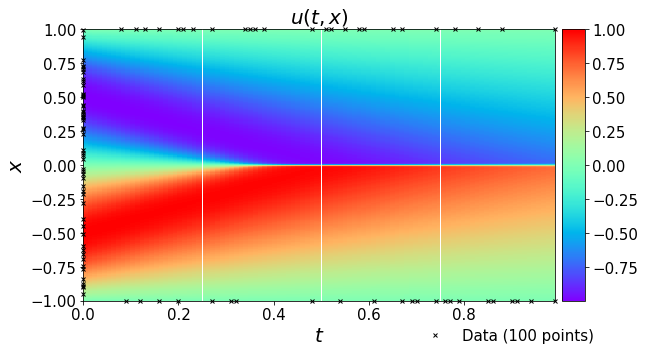

In [ ]:
""" The aesthetic setting has changed. """

####### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    X_u_train[:,1], 
    X_u_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.show()

# **Visualizations**

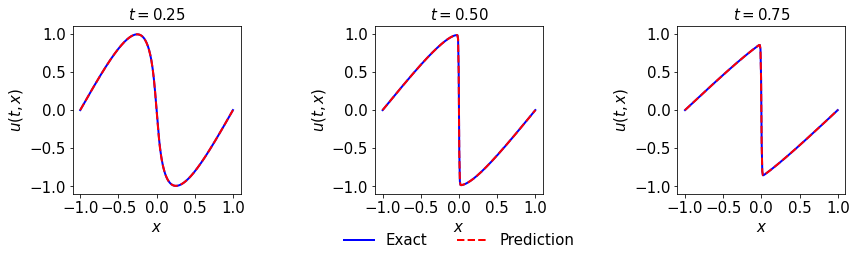

In [ ]:
####### Row 1: u(t,x) slices ################## 

""" The aesthetic setting has changed. """

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)

gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 15)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 15)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.show()

Text(0.5, 1.0, 'test error')

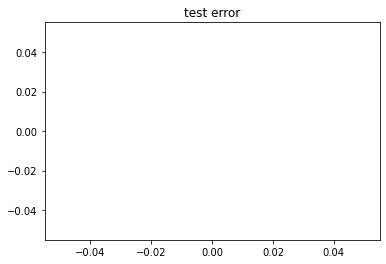

In [ ]:
import matplotlib

x_axis = [i for i in range(1,len(error_list)+1)]

plt.plot(x_axis, error_list)
plt.title("test error")